In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import lib.crps as crps
import lib.utils as utils

In [2]:
from run_crps import CRPSModel as CRPSModelSimple
from run_crps_weighted import CRPSModel as CRPSModelWeighted
from run_mdn_10 import MDN as MDN

In [3]:
device="cuda:"+str(utils.select_gpu_with_low_usage())

In [4]:
crps_simple = CRPSModelSimple(1, 2).to(device)
crps_simple.load_state_dict(torch.load('results/crps/99.pt', map_location=device))
crps_weighted = CRPSModelWeighted(1, 2).to(device)
crps_weighted.load_state_dict(torch.load('results/crps_weighted/99.pt', map_location=device))
mdn_10 = MDN(1, 2, 10).to(device)
mdn_10.load_state_dict(torch.load('results/mdn_10/99.pt', map_location=device))
mdn_100 = MDN(1, 2, 100).to(device)
mdn_100.load_state_dict(torch.load('results/mdn_100/99.pt', map_location=device))

<All keys matched successfully>

In [5]:
x_samp_raw = np.random.uniform(-2, 2, size=2000000)
y_samp_raw = np.random.uniform(-2, 2, size=2000000)
norm_samp_raw = x_samp_raw**2+y_samp_raw**2
circle_mask = norm_samp_raw<=2**2
x_samp = x_samp_raw[circle_mask]
y_samp = y_samp_raw[circle_mask]
norm_samp = norm_samp_raw[circle_mask]

train_X = torch.tensor(norm_samp, dtype=torch.float32).view(-1,1)
train_y = torch.stack([
    torch.tensor(x_samp, dtype=torch.float32),
    torch.tensor(y_samp, dtype=torch.float32),
], dim=0).T

def prepare_training(net, X_train, y_train):
    device = next(net.parameters()).device
    Xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train_s = torch.tensor(Xscaler.fit_transform(X_train), device=device, dtype=torch.float)
    y_train_s = torch.tensor(yscaler.fit_transform(y_train), device=device, dtype=torch.float)
    return X_train_s, y_train_s, (Xscaler, yscaler)

X_train_s, y_train_s, scalers = prepare_training(crps_simple, train_X, train_y)
(Xscaler, yscaler) = scalers

In [6]:
bins = np.linspace(-1.2, 1.2, 100)

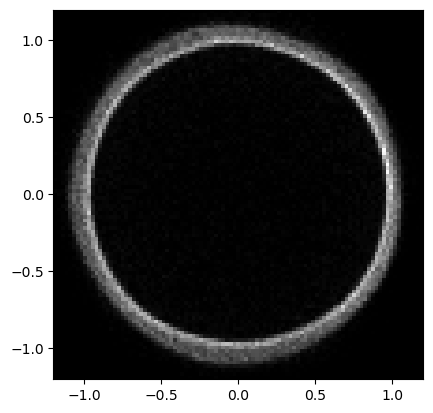

In [7]:
irt = Xscaler.transform([[1]]) # type: ignore
with torch.no_grad():
    samples_1 = crps_simple(torch.tensor(irt).float().to(device), n_samples=100000)
plt.figure()
plt.hist2d(*samples_1.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
plt.gca().set_aspect(1)
plt.gca().set_facecolor('black')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()
plt.close()

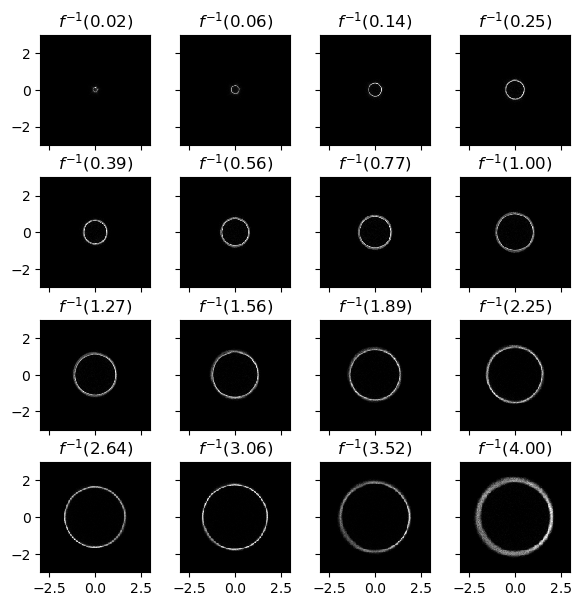

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)
(Xscaler, yscaler) = scalers
for i, ax in zip(np.linspace(0, 2, 4*4+1)[1:]**2, axs.reshape(-1)):
    irt = Xscaler.transform([[i]]) # type: ignore
    with torch.no_grad():
        sample = crps_simple(torch.tensor(irt).float().to(device), n_samples=100000)
    ax.hist2d(*sample.squeeze().T.cpu().numpy(), bins=100, cmap='gray', rasterized=True)
    ax.set_aspect('equal')
    ax.set_title("$f^{-1}(%.2f)$"%i)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('k')
fig.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid_crps.pdf', bbox_inches='tight')
plt.savefig('plots/paraboloid_crps.png', bbox_inches='tight')
plt.show()
plt.close()

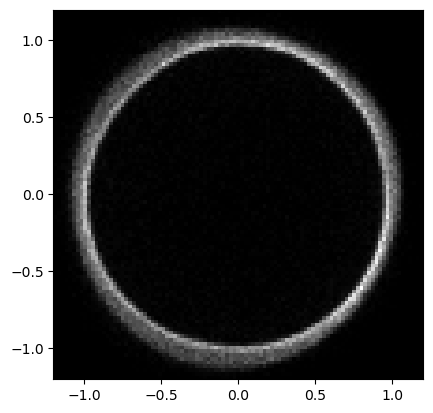

In [9]:
irt = Xscaler.transform([[1]]) # type: ignore
with torch.no_grad():
    samples_2, weights = crps_weighted(torch.tensor(irt).float().to(device), n_samples=100000)
plt.figure()
plt.hist2d(*samples_2.squeeze().T.cpu().numpy(), weights=weights.squeeze().cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
plt.gca().set_aspect(1)
plt.gca().set_facecolor('black')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()
plt.close()

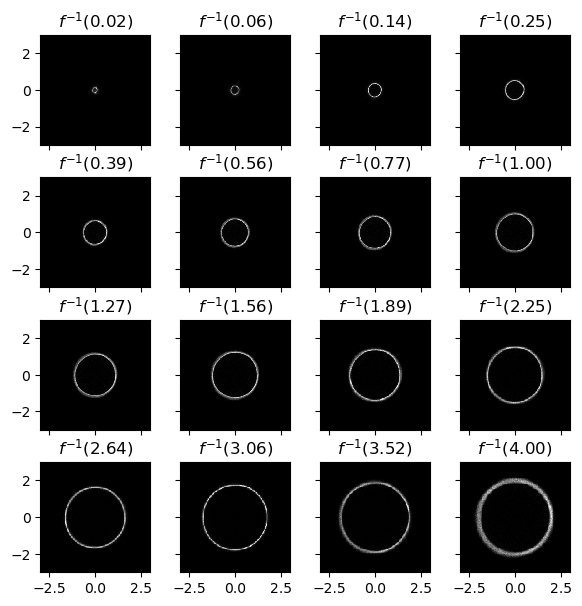

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)
(Xscaler, yscaler) = scalers
for i, ax in zip(np.linspace(0, 2, 4*4+1)[1:]**2, axs.reshape(-1)):
    irt = Xscaler.transform([[i]]) # type: ignore
    with torch.no_grad():
        sample, weights = crps_weighted(torch.tensor(irt).float().to(device), n_samples=100000)
    ax.hist2d(*sample.squeeze().T.cpu().numpy(), weights=weights.squeeze().cpu().numpy(), bins=100, cmap='gray', rasterized=True)
    ax.set_aspect('equal')
    ax.set_title("$f^{-1}(%.2f)$"%i)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('k')
fig.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid_wcrps.pdf', bbox_inches='tight')
plt.savefig('plots/paraboloid_wcrps.png', bbox_inches='tight')
plt.show()
plt.close()

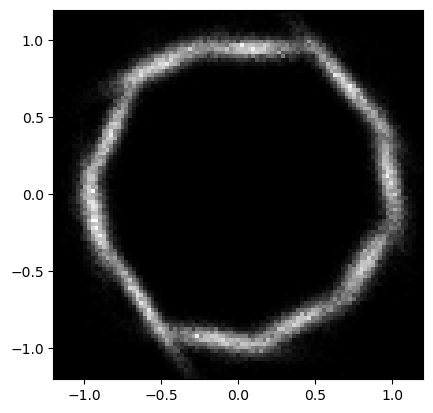

In [11]:
irt = Xscaler.transform([[1]]) # type: ignore
with torch.no_grad():
    p = mdn_10(torch.tensor(irt).float().to(device))
    samples_3 = mdn_10.mdn_mv_util.get_dist(p).sample((100000,)) # type: ignore
plt.figure()
plt.hist2d(*samples_3.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True) # type: ignore
plt.gca().set_aspect(1)
plt.gca().set_facecolor('black')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()
plt.close()

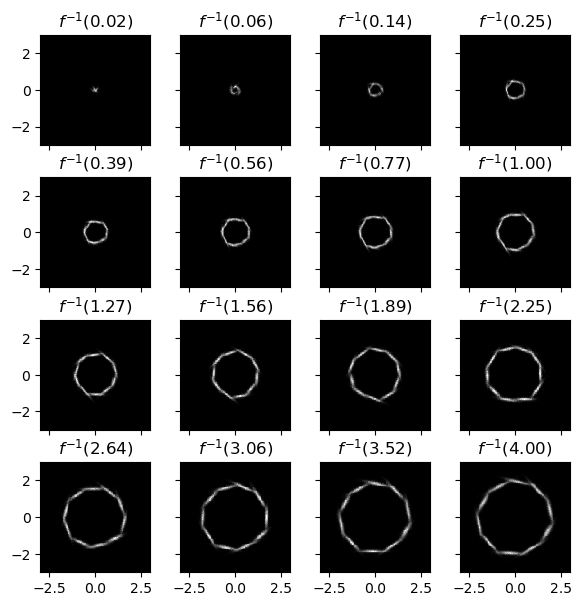

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)
(Xscaler, yscaler) = scalers
for i, ax in zip(np.linspace(0, 2, 4*4+1)[1:]**2, axs.reshape(-1)):
    irt = Xscaler.transform([[i]]) # type: ignore
    with torch.no_grad():
        p = mdn_10(torch.tensor(irt).float().to(device))
        samples = mdn_10.mdn_mv_util.get_dist(p).sample((100000,)) # type: ignore
    ax.hist2d(*samples.squeeze().T.cpu().numpy(), bins=100, cmap='gray', rasterized=True)
    ax.set_aspect('equal')
    ax.set_title("$f^{-1}(%.2f)$"%i)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('k')
fig.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid_mdn10.pdf', bbox_inches='tight')
plt.savefig('plots/paraboloid_mdn10.png', bbox_inches='tight')
plt.show()
plt.close()

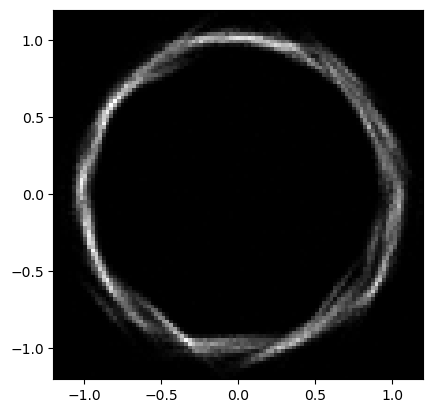

In [13]:
irt = Xscaler.transform([[1]]) # type: ignore
with torch.no_grad():
    p = mdn_100(torch.tensor(irt).float().to(device))
    samples_4 = mdn_100.mdn_mv_util.get_dist(p).sample((100000,)) # type: ignore
plt.figure()
plt.hist2d(*samples_4.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True) # type: ignore
plt.gca().set_aspect(1)
plt.gca().set_facecolor('black')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()
plt.close()

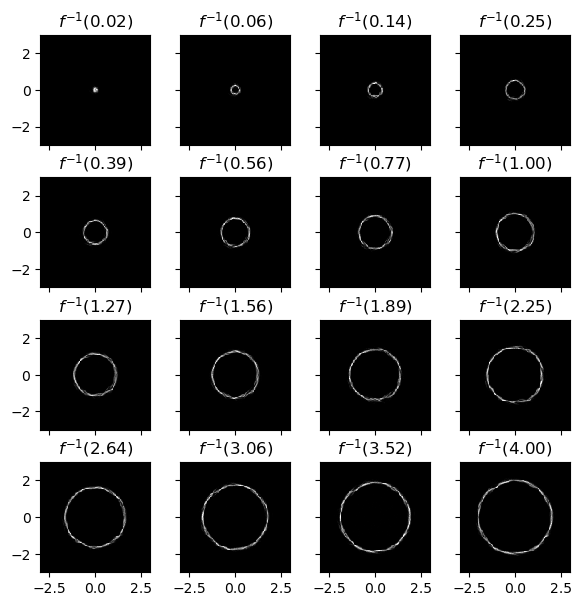

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)
(Xscaler, yscaler) = scalers
for i, ax in zip(np.linspace(0, 2, 4*4+1)[1:]**2, axs.reshape(-1)):
    irt = Xscaler.transform([[i]]) # type: ignore
    with torch.no_grad():
        p = mdn_100(torch.tensor(irt).float().to(device))
        samples = mdn_100.mdn_mv_util.get_dist(p).sample((100000,)) # type: ignore
    ax.hist2d(*samples.squeeze().T.cpu().numpy(), bins=100, cmap='gray', rasterized=True)
    ax.set_aspect('equal')
    ax.set_title("$f^{-1}(%.2f)$"%i)
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('k')
fig.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid_mdn100.pdf', bbox_inches='tight')
plt.savefig('plots/paraboloid_mdn100.png', bbox_inches='tight')
plt.show()
plt.close()

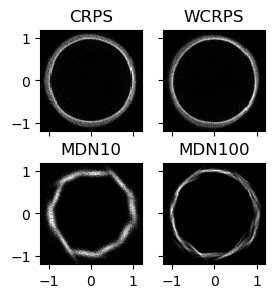

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(3, 3), sharex=True, sharey=True)
[ax1, ax2, ax3, ax4] = axs.reshape(-1)
for ax in axs.reshape(-1):
    ax.set_facecolor('black')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect(1)
ax1.set_title('CRPS')
ax1.hist2d(*samples_1.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
ax2.set_title('WCRPS')
ax2.hist2d(*samples_2.squeeze().T.cpu().numpy(), weights=weights.squeeze().cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
ax3.set_title('MDN10')
ax3.hist2d(*samples_3.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True) # type: ignore
ax4.set_title('MDN100')
ax4.hist2d(*samples_4.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True); # type: ignore
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid.pdf', bbox_inches='tight')

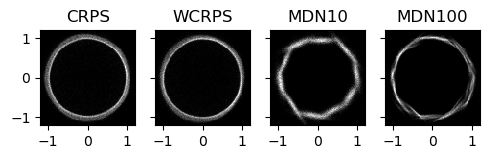

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(5, 2), sharex=True, sharey=True)
[ax1, ax2, ax3, ax4] = axs.reshape(-1)
for ax in axs.reshape(-1):
    ax.set_facecolor('black')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect(1)
ax1.set_title('CRPS')
ax1.hist2d(*samples_1.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
ax2.set_title('WCRPS')
ax2.hist2d(*samples_2.squeeze().T.cpu().numpy(), weights=weights.squeeze().cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True)
ax3.set_title('MDN10')
ax3.hist2d(*samples_3.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True) # type: ignore
ax4.set_title('MDN100')
ax4.hist2d(*samples_4.squeeze().T.cpu().numpy(), bins=(bins, bins), cmap='gray', rasterized=True); # type: ignore
plt.subplots_adjust(wspace=-0.4, hspace=-0.5)
plt.tight_layout()
plt.savefig('plots/paraboloid_vert.pdf', bbox_inches='tight')